In [ ]:
#run in virtual environment called.... tf2 is working fine for me 

In [12]:
# plot one photograph and mask
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot

In [13]:
import tensorflow as tf
sess = tf.compat.v1.Session()
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [19]:
# class that defines and loads the kangaroo dataset
class PeaksDataset(Dataset):
# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "peak")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			#if image_id in ['00090']:
			if image_id in ['5']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 10:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 10:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			x = int(box.find('x').text)
			y = int(box.find('y').text)
			coors = [x, y]
			boxes.append(coors)
		return boxes
 
	# load the masks for an image
#	def load_mask(self, image_id, image):
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		#image_shape determines the shape of the mask
		masks = zeros([image.shape[0], image.shape[1], len(boxes)], dtype='uint8')
#		print('masks', masks)
		# create masks
		class_ids = list()
		#print('boxes',boxes)
		for i in range(len(boxes)):
			box = boxes[i]
			 #we have the -3 and +3 to create an average sized box around each peak (rather than a point)
			row_s, row_e = box[0]-3, box[0]+3
			col_s, col_e = box[1]-3, box[1]+3
			#print('row_s:',row_s, 'row_e:', row_e, 'col_s:', col_s, 'col_e:',col_e)
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('peak'))
		return masks, asarray(class_ids, dtype='int32')
 
	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']
 

In [20]:
training_directory = 'D:/hl585/peak_findingNN/training_data/find_peaks_stat'

image shape: (144, 144, 3)
mask shape: (144, 144, 33)
number of peaks: 33


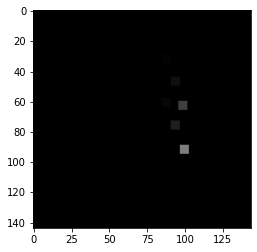

In [21]:
# train set
train_set = PeaksDataset()
#train_set.load_dataset('Mask_RCNN/kangaroo', is_train=True)
train_set.load_dataset(training_directory, is_train=True)
train_set.prepare()
# load an image
image_id = 1
image = train_set.load_image(image_id)
print('image shape:', image.shape)

# load image mask
#mask, class_ids = train_set.load_mask(image_id, image)
mask, class_ids = train_set.load_mask(image_id)
print('mask shape:', mask.shape)
# plot image
#pyplot.imshow(image)
# plot mask
#mask[:, :, 0] -> the 0 here means that the mask of the first peak is plotted
number_of_peaks = mask.shape[2]
print('number of peaks:', number_of_peaks)
for i in range(number_of_peaks):
    #this line of code doesn't really work because the masks block each other out as they layer on top of each other
    pyplot.imshow(mask[:, :, i], cmap='gray', alpha=0.5)
pyplot.show()

In [24]:
#train set
train_set = PeaksDataset()
train_set.load_dataset(training_directory, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = PeaksDataset()
test_set.load_dataset(training_directory, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 8
Test: 7


In [25]:
# display image with masks and bounding boxes
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

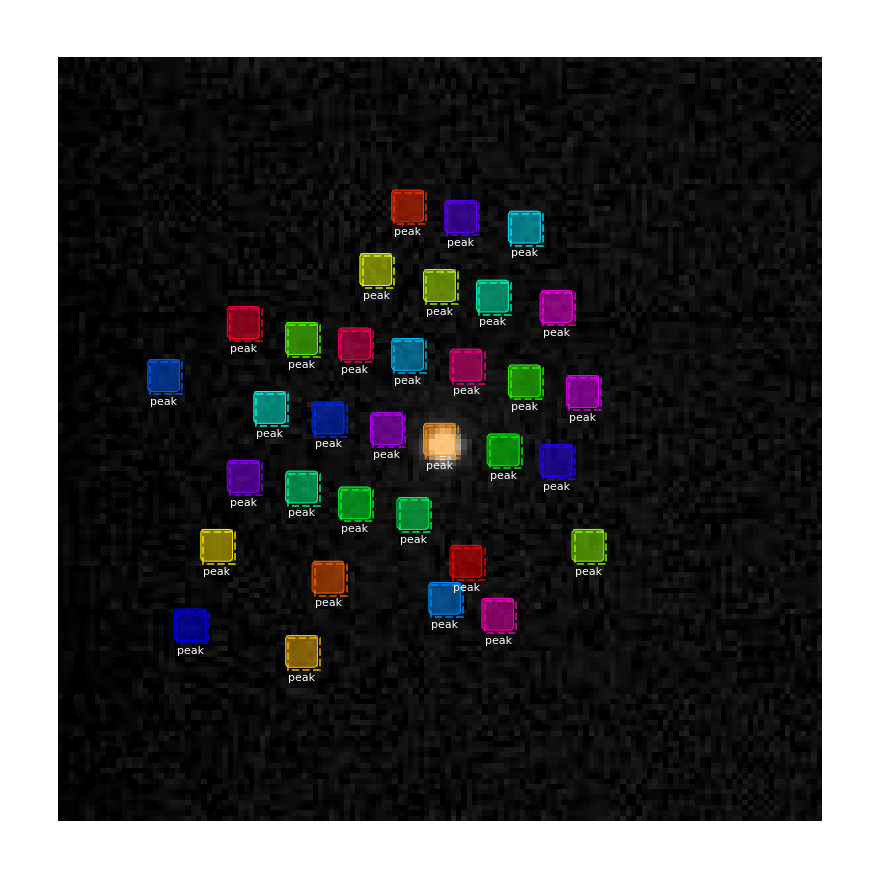

In [26]:
# define image id
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
#print(mask)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [27]:
# fit a mask rcnn on the kangaroo dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


In [28]:
# define a configuration for the model
class PeaksConfig(Config):
	# define the name of the configuration
	NAME = "peaks_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131

In [29]:
from tensorflow.python.client import device_lib
print('is a GPU available:', tf.test.is_gpu_available())
print('gpu device name:', tf.test.gpu_device_name())
print(device_lib.list_local_devices())
print('tf version', tf.__version__)
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

is a GPU available: True
gpu device name: /device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4764139774381699216
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15132721152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6425608902653977871
physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
tf version 1.15.3


In [30]:
# prepare train set
train_set = PeaksDataset()
train_set.load_dataset(training_directory, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = PeaksDataset()
test_set.load_dataset(training_directory, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# prepare config
config = PeaksConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
#model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=2, layers='heads')

Train: 8
Test: 7

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MA

C:\Users\Sauron\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Sauron\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Sauron\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "











Epoch 1/2
131/131 [==============================] - 480s 4s/step - loss: 11.4412 - rpn_class_loss: 2.0402 - rpn_bbox_loss: 6.7705 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 2.4094 - mrcnn_mask_loss: 0.1757 - val_loss: 12.9623 - val_rpn_class_loss: 0.2405 - val_rpn_bbox_loss: 10.9500 - val_mrcnn_class_loss: 0.0036 - val_mrcnn_bbox_loss: 1.6461 - val_mrcnn_mask_loss: 0.1221

Epoch 2/2
131/131 [==============================] - 463s 4s/step - loss: 7.0023 - rpn_class_loss: 0.6437 - rpn_bbox_loss: 4.6502 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 1.3168 - mrcnn_mask_loss: 0.3148 - val_loss: 2.9899 - val_rpn_class_loss: 0.4029 - val_rpn_bbox_loss: 2.5870 - val_mrcnn_class_loss: 9.7751e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


In [79]:
# evaluate the mask rcnn model on the peaks dataset
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# define a configuration for the model
class PeaksConfig(Config):
	# define the name of the configuration
	NAME = "peaks_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131
    
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "peaks_cfg"
	# number of classes (background + peak)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
 
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP
 
# load the train dataset
train_set = PeaksDataset()
train_set.load_dataset(training_directory, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = PeaksDataset()
test_set.load_dataset(training_directory, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_kangaroo_cfg_0002.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train: 8
Test: 7


AttributeError: 'str' object has no attribute 'decode'